In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX"]

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MGIC    1259 non-null   float64
 1   NSIT    1259 non-null   float64
 2   ON      1259 non-null   float64
 3   TTD     1259 non-null   float64
 4   IDXX    1259 non-null   float64
 5   BDSI    1259 non-null   float64
 6   CDMO    1259 non-null   float64
 7   ICLR    1259 non-null   float64
 8   MEDP    1259 non-null   float64
 9   OPRX    1259 non-null   float64
 10  RGEN    1259 non-null   float64
 11  TNDM    1259 non-null   float64
 12  XOMA    1259 non-null   float64
 13  CBRE    1259 non-null   float64
 14  SBAC    1259 non-null   float64
 15  ODFL    1259 non-null   float64
 16  GLDD    1259 non-null   float64
 17  HSON    1259 non-null   float64
 18  KRNT    1259 non-null   float64
 19  QRHC    1259 non-null   float64
 20  RCII    1259 non-null   float64
 21  SAIA    1259 non-nu

## Function that saves dataframe to CSV

In [4]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [5]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Close']
    save_dataframe_to_csv('close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [6]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [7]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [8]:
for ticker in tickers:
    df = get_df_from_csv('close', ticker)
    add_daily_return_to_df('close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [9]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('close', x)
    
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [10]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Close'].item()

## Returns the value of portfolio by date

In [11]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [12]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [13]:
#change to the list of stocks we using
port_list = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX"]

#add in the weightage of stocks
port_shares = [0.056508,0.046601,0.006341,0.130548,0.038795,0.006555,0.015181,0.013922,0.004819,0.035141,0.037627,
              0.000394,0.007568,0.051494,0.108506,0.062501,0.000536,0.006388,0.006606,0.005183,0.002574,0.000174,
              0.002497,0.033541,0.001614,0.037578,0.009430,0.025462,0.004964,0.009947,0.031003, 0.200000]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.389905,1.895729,0.080467,0.351566,4.562292,0.011471,0.031880,1.040113,0.173050,0.085393,...,0.090714,1.630810,0.467414,0.143573,0.200943,0.267077,2.072551,0.3888,32.394128,NaN
2017-01-04,0.392731,1.929281,0.082433,0.353785,4.498280,0.011471,0.032943,1.069488,0.175363,0.084338,...,0.093612,1.705966,0.468200,0.147385,0.201985,0.277521,2.151918,0.3894,32.686957,0.009040
2017-01-05,0.395556,1.894797,0.081482,0.358354,4.498668,0.012127,0.031880,1.060996,0.172665,0.085393,...,0.092514,1.704162,0.467885,0.146114,0.203276,0.278019,2.130836,0.3726,32.422003,-0.008106
2017-01-06,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
2017-01-09,0.392731,1.863108,0.084589,0.371279,4.617381,0.012127,0.031880,1.118911,0.172135,0.083284,...,0.091933,1.738208,0.454840,0.152467,0.192702,0.273542,2.114095,0.3762,32.358261,-0.001706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.209836,4.846504,0.442475,12.751929,25.404519,0.020648,0.459529,4.282686,1.098250,2.226182,...,0.250638,41.108075,2.236702,0.691548,0.977709,1.646129,12.424452,0.2504,196.697289,0.020705
2021-12-28,1.190624,4.859552,0.433217,12.374645,25.266409,0.020386,0.444500,4.260828,1.051988,2.134113,...,0.250202,40.902525,2.252073,0.692821,0.975277,1.634790,12.403370,0.2490,195.338608,-0.006907
2021-12-29,1.192884,4.942502,0.437085,12.084828,25.437494,0.020320,0.460136,4.287837,1.062445,2.090538,...,0.250767,40.816846,2.258862,0.691803,1.023477,1.642847,12.432203,0.2588,195.846235,0.002599


## Get old data for portfolio

In [23]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.389905,1.895729,0.080467,0.351566,4.562292,0.011471,0.031880,1.040113,0.173050,0.085393,...,0.090714,1.630810,0.467414,0.143573,0.200943,0.267077,2.072551,0.3888,32.394128,NaN
2017-01-04,0.392731,1.929281,0.082433,0.353785,4.498280,0.011471,0.032943,1.069488,0.175363,0.084338,...,0.093612,1.705966,0.468200,0.147385,0.201985,0.277521,2.151918,0.3894,32.686957,0.009040
2017-01-05,0.395556,1.894797,0.081482,0.358354,4.498668,0.012127,0.031880,1.060996,0.172665,0.085393,...,0.092514,1.704162,0.467885,0.146114,0.203276,0.278019,2.130836,0.3726,32.422003,-0.008106
2017-01-06,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
2017-01-09,0.392731,1.863108,0.084589,0.371279,4.617381,0.012127,0.031880,1.118911,0.172135,0.083284,...,0.091933,1.738208,0.454840,0.152467,0.192702,0.273542,2.114095,0.3762,32.358261,-0.001706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.209836,4.846504,0.442475,12.751929,25.404519,0.020648,0.459529,4.282686,1.098250,2.226182,...,0.250638,41.108075,2.236702,0.691548,0.977709,1.646129,12.424452,0.2504,196.697289,0.020705
2021-12-28,1.190624,4.859552,0.433217,12.374645,25.266409,0.020386,0.444500,4.260828,1.051988,2.134113,...,0.250202,40.902525,2.252073,0.692821,0.975277,1.634790,12.403370,0.2490,195.338608,-0.006907
2021-12-29,1.192884,4.942502,0.437085,12.084828,25.437494,0.020320,0.460136,4.287837,1.062445,2.090538,...,0.250767,40.816846,2.258862,0.691803,1.023477,1.642847,12.432203,0.2588,195.846235,0.002599


## Forecasting

In [24]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [25]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [26]:
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.389905,1.895729,0.080467,0.351566,4.562292,0.011471,0.031880,1.040113,0.173050,0.085393,...,0.090714,1.630810,0.467414,0.143573,0.200943,0.267077,2.072551,0.3888,32.394128,NaN
2017-01-04,0.392731,1.929281,0.082433,0.353785,4.498280,0.011471,0.032943,1.069488,0.175363,0.084338,...,0.093612,1.705966,0.468200,0.147385,0.201985,0.277521,2.151918,0.3894,32.686957,0.009040
2017-01-05,0.395556,1.894797,0.081482,0.358354,4.498668,0.012127,0.031880,1.060996,0.172665,0.085393,...,0.092514,1.704162,0.467885,0.146114,0.203276,0.278019,2.130836,0.3726,32.422003,-0.008106
2017-01-06,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
2017-01-07,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.209836,4.846504,0.442475,12.751929,25.404519,0.020648,0.459529,4.282686,1.098250,2.226182,...,0.250638,41.108075,2.236702,0.691548,0.977709,1.646129,12.424452,0.2504,196.697289,0.020705
2021-12-28,1.190624,4.859552,0.433217,12.374645,25.266409,0.020386,0.444500,4.260828,1.051988,2.134113,...,0.250202,40.902525,2.252073,0.692821,0.975277,1.634790,12.403370,0.2490,195.338608,-0.006907
2021-12-29,1.192884,4.942502,0.437085,12.084828,25.437494,0.020320,0.460136,4.287837,1.062445,2.090538,...,0.250767,40.816846,2.258862,0.691803,1.023477,1.642847,12.432203,0.2588,195.846235,0.002599


In [27]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [28]:
tot_port_df

,Total
Date,
2017-01-03,32.394128
2017-01-04,32.686957
2017-01-05,32.422003
2017-01-06,32.413547
2017-01-07,32.413547
...,...
2021-12-27,196.697289
2021-12-28,195.338608
2021-12-29,195.846235


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


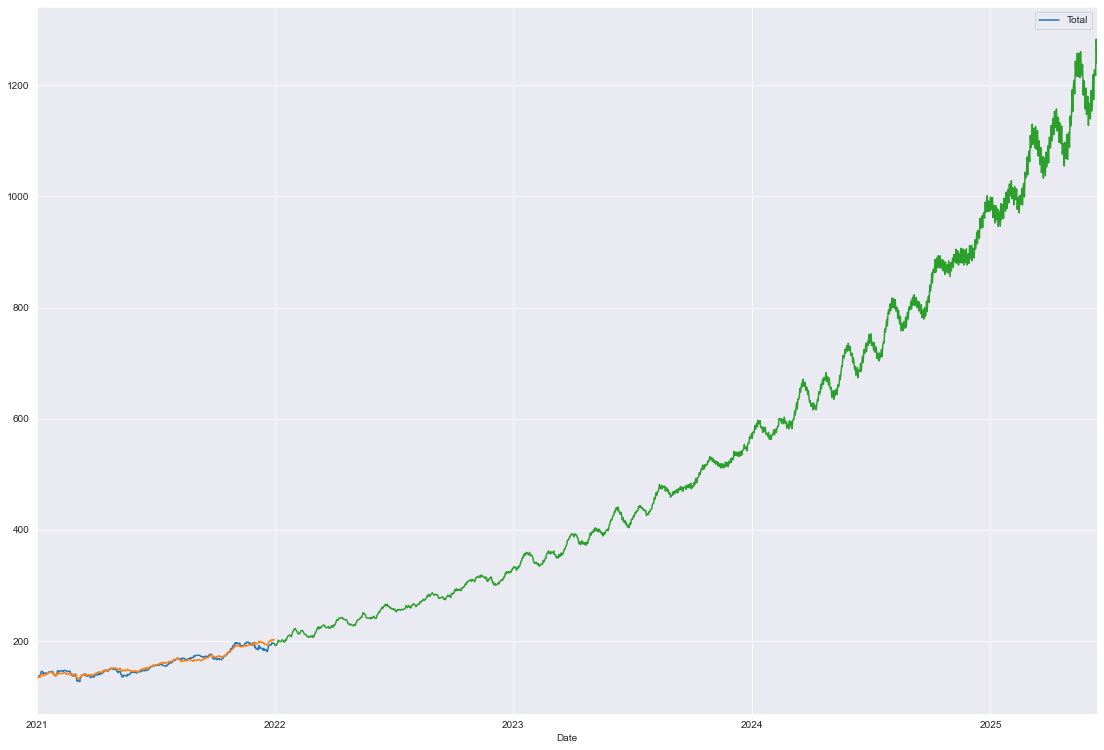

In [29]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [30]:
forecast

2021-12-31     194.858985
2022-01-01     193.043624
2022-01-02     191.325582
2022-01-03     192.554840
2022-01-04     194.871704
                 ...     
2025-06-09    1227.041310
2025-06-10    1227.814341
2025-06-11    1217.874419
2025-06-12    1282.785692
2025-06-13    1240.181944
Freq: D, Length: 1261, dtype: float64

In [31]:
forecast_df = pd.DataFrame(forecast)

In [32]:
forecast_df

,0
2021-12-31,194.858985
2022-01-01,193.043624
2022-01-02,191.325582
2022-01-03,192.554840
2022-01-04,194.871704
...,...
2025-06-09,1227.041310
2025-06-10,1227.814341
2025-06-11,1217.874419
2025-06-12,1282.785692


In [33]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [34]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.009316
2022-01-02,-0.018133
2022-01-03,-0.011825
2022-01-04,0.000065
...,...
2025-06-09,5.297073
2025-06-10,5.301040
2025-06-11,5.250030
2025-06-12,5.583149


In [35]:
#calculate annualized volatility
annualized_vol = np.sqrt(np.log(forecast / forecast.shift(1)).var()) * np.sqrt(252)
annualized_vol*100

24.073330125354897